## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

### Importing all Datasets

In [2]:
fifa_players = pd.read_csv('fifa_players.csv')
country_happiness_report = pd.read_csv('country_happiness_report.csv')
all_int_football_results = pd.read_csv('all_int_football_results.csv')
worldBank = pd.read_csv('worldBank.csv')
# fifa_players.head()
# country_happiness_report.head()
# all_int_football_results.head()
# worldBank.head()

### Data Cleaning

#### World Bank Data - Greg

In [3]:
#drop redundant columns
worldBank = worldBank.drop(columns='Indicator Code')
worldBank = worldBank.drop(columns='Country Code')

#drop non-countries
notCountries = list(worldBank['Country Name'].unique()[:41])
worldBank = worldBank[~worldBank['Country Name'].isin(notCountries)]
# print(worldBank.head())

#wide to long
worldBankMelt = worldBank.melt(id_vars=['Country Name', 'Indicator Name'], var_name='Year', value_name='Value')
worldBankMelt.head()


,Country Name,Indicator Name,Year,Value
0,Afghanistan,% of females ages 15-49 having comprehensive c...,1960,NaN
1,Afghanistan,% of males ages 15-49 having comprehensive cor...,1960,NaN
2,Afghanistan,"Adolescent fertility rate (births per 1,000 wo...",1960,145.321
3,Afghanistan,Adults (ages 15+) and children (0-14 years) li...,1960,NaN
4,Afghanistan,Adults (ages 15+) and children (ages 0-14) new...,1960,NaN


In [4]:
#multiindex pivot function
def multiindex_pivot(df, columns=None, values=None):
    #https://github.com/pandas-dev/pandas/issues/23955
    names = list(df.index.names)
    df = df.reset_index()
    list_index = df[names].values
    tuples_index = [tuple(i) for i in list_index] # hashable
    df = df.assign(tuples_index=tuples_index)
    df = df.pivot(index="tuples_index", columns=columns, values=values)
    tuples_index = df.index  # reduced
    index = pd.MultiIndex.from_tuples(tuples_index, names=names)
    df.index = index
    return df

#set index
worldBankIndex = worldBankMelt.set_index(['Country Name', 'Year'])

#multiindex pivot
worldBankIndex = multiindex_pivot(worldBankIndex, 'Indicator Name', 'Value')

#drop index
wb = worldBankIndex.reset_index()

#drop unnamed years
wb = wb[wb['Year'] != 'Unnamed: 60']

#year as integer
wb['Year'] = wb['Year'].astype(int)

wb.head()


Indicator Name,Country Name,Year,% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions),% of males ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions),AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,...,Urban population,Urban population (% of total),Urban population growth (annual %),Urban poverty headcount ratio at national poverty lines (% of urban population),"Use of Intermittent Preventive Treatment of malaria, 2+ doses of SP/Fansidar (% of pregnant women)",Use of any antimalarial drug (% of pregnant women),Use of insecticide-treated bed nets (% of under-5 population),Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women's share of population ages 15+ living with HIV (%)
0,Afghanistan,1960,NaN,NaN,NaN,NaN,145.321,NaN,NaN,NaN,...,739462.0,8.221,5.253807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1961,NaN,NaN,NaN,NaN,145.321,NaN,NaN,NaN,...,779754.0,8.508,5.305559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1962,NaN,NaN,NaN,NaN,145.321,NaN,NaN,NaN,...,822719.0,8.805,5.363622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1963,NaN,NaN,NaN,NaN,145.321,NaN,NaN,NaN,...,868325.0,9.110,5.395136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1964,NaN,NaN,NaN,NaN,145.321,NaN,NaN,NaN,...,917022.0,9.426,5.456539,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#attribute selection
wb_cols = [
    'Population, total',
    'Population, female',
    'Population, male',
    'Life expectancy at birth, total (years)',
    'Life expectancy at birth, female (years)',
    'Life expectancy at birth, male (years)',
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Age dependency ratio (% of working-age population)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Fertility rate, total (births per woman)',
    'GNI per capita, Atlas method (current US$)',
    'Health expenditure per capita (current US$)',
    'Mortality rate, adult, male (per 1,000 male adults)',
    'Mortality rate, adult, female (per 1,000 female adults)',
    'Mortality rate, infant (per 1,000 live births)',
    'Rural population (% of total population)',
    'School enrollment, primary (% gross)',
    'School enrollment, secondary (% gross)',
    'School enrollment, tertiary (% gross)',
    'Unemployment, total (% of total labor force)',
    'Urban population (% of total)'
]

In [6]:
#fill in missing values, ideally fill in with country average if available, 
#global average if not
#starting point
wb[wb_cols] = wb[wb_cols].transform(lambda x: x.fillna(x.mean()))

#normalize
wb[wb_cols] = wb[wb_cols].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

wb_cols.insert(0,'Year')
wb_cols.insert(0,'Country Name' ) 

wb = wb[wb_cols] 

print(wb.isna().sum())

wb.head()

Indicator Name
Country Name                                                     0
Year                                                             0
Population, total                                                0
Population, female                                               0
Population, male                                                 0
Life expectancy at birth, total (years)                          0
Life expectancy at birth, female (years)                         0
Life expectancy at birth, male (years)                           0
Adolescent fertility rate (births per 1,000 women ages 15-19)    0
Age dependency ratio (% of working-age population)               0
Birth rate, crude (per 1,000 people)                             0
Death rate, crude (per 1,000 people)                             0
Fertility rate, total (births per woman)                         0
GNI per capita, Atlas method (current US$)                       0
Health expenditure per capita (current US$)    

Indicator Name,Country Name,Year,"Population, total","Population, female","Population, male","Life expectancy at birth, total (years)","Life expectancy at birth, female (years)","Life expectancy at birth, male (years)","Adolescent fertility rate (births per 1,000 women ages 15-19)",Age dependency ratio (% of working-age population),...,Health expenditure per capita (current US$),"Mortality rate, adult, male (per 1,000 male adults)","Mortality rate, adult, female (per 1,000 female adults)","Mortality rate, infant (per 1,000 live births)",Rural population (% of total population),"School enrollment, primary (% gross)","School enrollment, secondary (% gross)","School enrollment, tertiary (% gross)","Unemployment, total (% of total labor force)",Urban population (% of total)
0,Afghanistan,1960,0.006557,0.006512,0.006559,0.201854,0.166047,0.234299,0.616633,0.625339,...,0.076374,0.632565,0.676380,0.191555,0.937257,0.428287,0.380153,0.188453,0.224951,0.062743
1,Afghanistan,1961,0.006681,0.006649,0.006672,0.208791,0.173054,0.241127,0.616633,0.635268,...,0.076374,0.625970,0.669066,0.867829,0.934326,0.428287,0.380153,0.188453,0.224951,0.065674
2,Afghanistan,1962,0.006811,0.006791,0.006791,0.215628,0.179937,0.247879,0.616633,0.640515,...,0.076374,0.619377,0.661750,0.852578,0.931293,0.428287,0.380153,0.188453,0.224951,0.068707
3,Afghanistan,1963,0.006948,0.006939,0.006918,0.222396,0.186742,0.254570,0.616633,0.642869,...,0.076374,0.613041,0.654903,0.838054,0.928178,0.428287,0.380153,0.188453,0.224951,0.071822
4,Afghanistan,1964,0.007092,0.007094,0.007051,0.229118,0.193486,0.261230,0.616633,0.644626,...,0.076374,0.606704,0.648055,0.824256,0.924951,0.428287,0.380153,0.188453,0.224951,0.075049


In [7]:
# Number of countries and years.
print("number of countries: ", len(wb['Country Name'].unique()))
print("number of years: ", len(wb['Year'].unique()))

print(wb.columns)

# rename columns
wb_cols_final = [
    'Country_Name',
    'Year',
    'Pop_total',
    'Pop_female',
    'Pop_male',
    'Life_expect_total',
    'Life_expect_female',
    'Life_expect_male',
    'Adolescent_fertility',
    'Age_dependency',
    'Birth_rate',
    'Death_rate',
    'Fertility_rate_total',
    'GNI',
    'Health_expenditure',
    'Mortality_adult_male',
    'Mortality_adult_female',
    'Mortality_infant',
    'Rural_pop',
    'School_primary_total',
    'School_secondary_total',
    'School_tertiary_total',
    'Unemployment_total',
    'Urban_pop',
]

wb.columns = wb_cols_final
print(np.array(wb.columns))

number of countries:  217
number of years:  56
Index(['Country Name', 'Year', 'Population, total', 'Population, female',
       'Population, male', 'Life expectancy at birth, total (years)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'GNI per capita, Atlas method (current US$)',
       'Health expenditure per capita (current US$)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Mortality rate, adult, female (per 1,000 female adults)',
       'Mortality rate, infant (per 1,000 live births)',
       'Rural population (% of total population)',
       'School enrollment, primary (% gross)',
       'School enrollment, secondary (% g

#### International Football Results Data - Greg

In [8]:
#limit to world cup results
worldCup = all_int_football_results[all_int_football_results['tournament'] == 'FIFA World Cup']

#create new year column from date column
# worldCup['Year'] = worldCup['date'].str.split('-').str[0].astype(int)
years = worldCup['date'].str.split('-').str[0].astype(int)
worldCup['Year'] = years

worldCup.head()

/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year
1300,1930-07-13,Belgium,United States,0,3,FIFA World Cup,Montevideo,Uruguay,True,1930
1301,1930-07-13,France,Mexico,4,1,FIFA World Cup,Montevideo,Uruguay,True,1930
1302,1930-07-14,Brazil,Yugoslavia,1,2,FIFA World Cup,Montevideo,Uruguay,True,1930
1303,1930-07-14,Peru,Romania,1,3,FIFA World Cup,Montevideo,Uruguay,True,1930
1304,1930-07-15,Argentina,France,1,0,FIFA World Cup,Montevideo,Uruguay,True,1930


##### Country Happiness Report Data - Cat

In [9]:
# minimize, clean, and aggregate country happiness data
# minimize number of attributes in set
# select a number of years for each country using broundaries.
# find the mean for each country
# for data with NAN values, data was NaN for all values in country.  Update with mean from column.
selected_attrs_country = [
    'country',
    'year', 
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

attrs_for_cleaning_nans = [
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

# minimize data set
selected_attrs_cols = [col for col in country_happiness_report.columns if col in selected_attrs_country]
country_data = country_happiness_report[selected_attrs_cols]


# group data by country and use mean for group override NAN with mean.
for attr in attrs_for_cleaning_nans:
    country_data[attr] = country_data.groupby('country', as_index=False)[attr].transform(lambda x: x.fillna(x.mean()))

# normalize data that was not collected on binary scale 0-1 
attr = ['Life Ladder', 'Log GDP per capita', 'Healthy life expectancy at birth', 'Generosity', 'Democratic Quality']
country_data[attr] = country_data[attr].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
country_data.head()


/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/saholly/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,Afghanistan,2008,0.194328,0.154278,0.450662,0.282865,0.718114,0.585529,0.517637,0.258195,0.612072,0.090414,0.281074
1,Afghanistan,2009,0.321535,0.184592,0.552308,0.290549,0.678896,0.610420,0.583926,0.237092,0.611545,0.059306,0.286315
2,Afghanistan,2010,0.388422,0.194407,0.539075,0.298000,0.600127,0.534141,0.618265,0.275324,0.299357,0.076649,0.275833
3,Afghanistan,2011,0.214610,0.199809,0.521104,0.305248,0.495901,0.577504,0.611387,0.267175,0.307386,0.095360,0.281074
4,Afghanistan,2012,0.205460,0.218759,0.520637,0.312385,0.530935,0.660130,0.710385,0.267919,0.435440,0.118169,0.281074


#### Fifa Players Data - Cat's code adjusted

In [10]:
# data cleaning
# minimize attributes used.
# fill national team based on nationality if value is null.
# fill numeric missing values with mean.
# fill categorical missing values with mode.
# normalize attribute values that are numeric for consistency in correlation
# sort players by overall rating.
top_player_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'positions',
    'value_euro',
    'wage_euro',
    'preferred_foot',
    'international_reputation(1-5)',
    'body_type',
    'national_team', # use nationality if na
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
top_player_fill_mean_attrs = [
    'overall_rating',
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
]
top_player_fill_mode_attrs = [
    'preferred_foot',
    'body_type',
]

fifa_top_players_data = fifa_players[top_player_attrs]

# data cleaning - fill by means and modes based on attr set or national_team with nationality.
fifa_top_players_data['national_team'] = fifa_players.national_team.fillna(fifa_top_players_data['nationality'])
fifa_top_players_data[top_player_fill_mean_attrs] = fifa_top_players_data[top_player_fill_mean_attrs].transform(lambda x: x.fillna(x.mean()))
fifa_top_players_data[top_player_fill_mode_attrs] = fifa_top_players_data[top_player_fill_mode_attrs].transform(lambda x: x.fillna(x.mode()))

# normalize numeric attr values
top_player_normalize_attrs = [
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]

# normalize
fifa_top_players_data[top_player_normalize_attrs] = fifa_top_players_data[top_player_normalize_attrs].apply(
                                                                        lambda x:(x-x.min()) / (x.max()-x.min()))

# fifa_top_players_data
fifa_top_players_data.head()

/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,full_name,nationality,overall_rating,positions,value_euro,wage_euro,preferred_foot,international_reputation(1-5),body_type,national_team,...,ball_control,acceleration,sprint_speed,agility,reactions,shot_power,jumping,stamina,strength,long_shots
0,Lionel Andrés Messi Cuccittini,Argentina,1.00000,"CF,RW,ST",110500000.0,565000.0,Left,5,Messi,Argentina,...,1.000000,0.929412,0.880952,0.964706,0.986111,0.892473,0.6625,0.705882,0.597403,1.000000
1,Christian Dannemann Eriksen,Denmark,0.87234,"CAM,RM,CM",69500000.0,205000.0,Right,3,Lean,Denmark,...,0.945055,0.752941,0.726190,0.811765,0.888889,0.881720,0.4375,0.941176,0.493506,0.945055
2,Paul Pogba,France,0.87234,"CM,CAM",73000000.0,255000.0,Right,4,Normal,France,...,0.934066,0.694118,0.797619,0.764706,0.805556,0.946237,0.8500,0.894118,0.870130,0.868132
3,Lorenzo Insigne,Italy,0.87234,"LW,ST",62000000.0,165000.0,Right,3,Normal,Italy,...,0.967033,0.964706,0.880952,0.976471,0.819444,0.784946,0.4750,0.741176,0.311688,0.890110
4,Kalidou Koulibaly,Senegal,0.87234,CB,60000000.0,135000.0,Right,3,Normal,Senegal,...,0.637363,0.682353,0.750000,0.458824,0.805556,0.569892,0.8250,0.741176,0.961039,0.131868


### Data Integration

In [11]:
# Current Dataframes
# worldCup.head()
# fifa_top_players_skills_data.columns
country_happiness_data = country_data
# country_happiness_data.head()
# wb.head()

In [12]:
# Add countries that are first, second, third place, and host in a World Cup

# Preprocessed data from Cat
successful_teams = pd.read_csv('historical_world_cup_top_three.csv')
successful_teams.head()

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.7
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607


In [13]:
#function to rename country names in worldCup to match worldBank country names, extended from Greg
def changeCountryName(country):
    if country == 'Yugoslavia': #Bosnia and Herzegovina, Croatia, Macedonia, Montanegro, Serbia, Slovenia
        return 'Serbia'
    if country == 'North Korea':
        return 'Korea, Dem. People’s Rep.'
    if country == 'Ivory Coast':
        return "Cote d'Ivoire"
    if country == 'Republic of Ireland':
        return 'Ireland'
    if country == 'Egypt':
        return 'Egypt, Arab Rep.'
    if country == 'Wales': #UK
        return 'United Kingdom'
    if country == 'Czechoslovakia':
        return 'Czech Republic' #Czech Republic, Slovakia
    if country == 'German DR':
        return 'Germany'
    if country == 'Germany FR':
        return 'Germany'
    if country == 'Slovakia':
        return 'Slovak Republic'
    if country == 'Scotland': #UK
        return 'United Kingdom'
    if country == 'DR Congo':
        return 'Congo, Dem. Rep.'
    if country == 'Northern Ireland': #UK
        return 'United Kingdom'
    if country == 'South Korea':
        return 'Korea, Rep.'
    if country == 'Russia':
        return 'Russian Federation'
    if country == 'China PR':
        return 'China'
    if country == 'England': #UK
        return 'United Kingdom'
    if country == 'Iran':
        return 'Iran, Islamic Rep.'
    if country == 'Congo (Brazzaville)':
        return 'Congo, Rep.'
    if country == 'Congo (Kinshasa)':
        return 'Congo, Dem. Rep.'
    if country == 'Dominican Republic':
        return 'Dominica'
    if country == 'Hong Kong':
        return 'Hong Kong SAR, China'
    if country == 'Kyrgyzstan':
        return 'Kyrgyz Republic'
    if country == 'Macedonia':
        return 'Macedonia, FYR'
    if country == 'Syria':
        return 'Syrian Arab Republic'
    if country == 'Venezuela':
        return 'Venezuela, RB'
    if country == 'Yemen':
        return 'Yemen, Rep.'
    return country

#change worldCup country names to match worldBank country names
worldCup['home_team'] = worldCup.apply(lambda row: changeCountryName(row['home_team']), axis=1)
worldCup['away_team'] = worldCup.apply(lambda row: changeCountryName(row['away_team']), axis=1)
successful_teams['Country'] = successful_teams.apply(lambda row: changeCountryName(row['Country']), axis=1)
successful_teams['Winner'] = successful_teams.apply(lambda row: changeCountryName(row['Winner']), axis=1)
successful_teams['Runners-Up'] = successful_teams.apply(lambda row: changeCountryName(row['Runners-Up']), axis=1)
successful_teams['Third'] = successful_teams.apply(lambda row: changeCountryName(row['Third']), axis=1)
country_happiness_data['country'] = country_happiness_data.apply(lambda row: changeCountryName(row['country']), axis=1)
fifa_top_players_data['nationality'] = fifa_top_players_data.apply(lambda row: changeCountryName(row['nationality']), axis=1)
fifa_top_players_data['national_team'] = fifa_top_players_data.apply(lambda row: changeCountryName(row['national_team']), axis=1)

/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [14]:
# converge successful countries to one list
winners = successful_teams.Winner.unique()
seconds = successful_teams['Runners-Up'].unique()
thirds = successful_teams.Third.unique()
hosts = successful_teams.Country.unique()

adjusted_hosts = []
for host in hosts:
    if host == "Korea/Japan":
        adjusted_hosts.append("Korea")
        adjusted_hosts.append("Japan")
    else:
        adjusted_hosts.append(host)

successful_countries = list(winners)
potential_doubles = list(seconds) + list(thirds) + list(adjusted_hosts)

for country in potential_doubles:
    double = False
    for team in successful_countries:
        if country == team:
            double = True
    if not double:
        successful_countries.append(country)
    
print(successful_countries)

['Uruguay', 'Italy', 'Germany', 'Brazil', 'United Kingdom', 'Argentina', 'France', 'Spain', 'Czech Republic', 'Hungary', 'Sweden', 'Netherlands', 'USA', 'Austria', 'Chile', 'Portugal', 'Poland', 'Croatia', 'Turkey', 'Switzerland', 'Mexico', 'Korea', 'Japan', 'South Africa']


/home/saholly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



All 164 countries in happiness report: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark'
 'Djibouti' 'Dominica' 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador'
 'Estonia' 'Ethiopia' 'Finland' 'France' 'Gabon' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran, Islamic Rep.' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, Rep.' 'Kosovo' 'Kuwait'
 'Kyrgyz Republic' 'Laos' 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya'
 

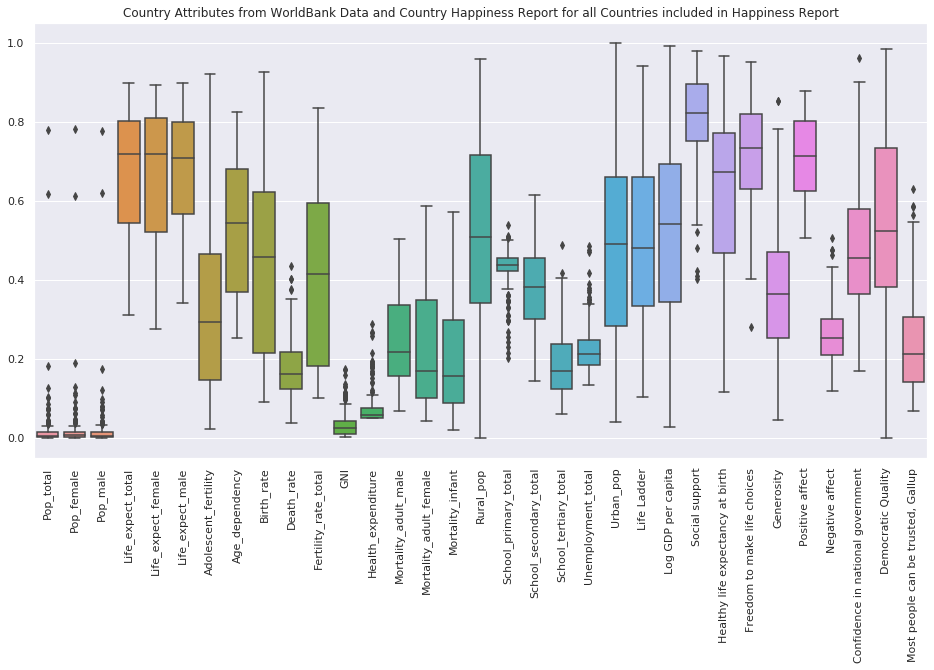

In [15]:
# visualize distribution of selected attributes averaged over all countries included in happiness report.
# limit worldBank data to range of years of happiness report data 
average_wb = wb[wb.Year >= 2005]
average_wb = wb.drop('Year', axis=1)
average_wb = average_wb.groupby("Country_Name").mean()

average_happy = country_happiness_data.drop('year', axis=1)
average_happy = average_happy.groupby('country').mean()

# delete countries in WorldBank data that are not included in happiness report.
single_countries = []
for wb_country in average_wb.index:
    if wb_country not in average_happy.index:
        single_countries.append(wb_country)

average_wb = average_wb.drop(single_countries)

# join datasets on country
joined_country_data = pd.concat([average_wb, average_happy], axis=1)
# print(joined_country_data.head())
print("All {} countries in happiness report: {}".format(len(np.array(joined_country_data.index)), 
                                                        np.array(joined_country_data.index)))


# plot averages for each country attribute
sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(data = joined_country_data).set_title(
    'Country Attributes from WorldBank Data and Country Happiness Report for all Countries included in Happiness Report')
plt.xticks(rotation=90);

All involved 74 countries: ['Algeria' 'Angola' 'Argentina' 'Australia' 'Austria' 'Belgium' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cameroon' 'Canada' 'Chile'
 'China' 'Colombia' 'Congo, Dem. Rep.' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Czech Republic' 'Denmark' 'Ecuador' 'Egypt, Arab Rep.'
 'El Salvador' 'France' 'Germany' 'Ghana' 'Greece' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'Indonesia' 'Iran, Islamic Rep.' 'Iraq' 'Ireland'
 'Israel' 'Italy' 'Jamaica' 'Japan' 'Korea, Rep.' 'Kuwait' 'Mexico'
 'Morocco' 'Netherlands' 'New Zealand' 'Nigeria' 'Norway' 'Panama'
 'Paraguay' 'Peru' 'Poland' 'Portugal' 'Romania' 'Russian Federation'
 'Saudi Arabia' 'Senegal' 'Serbia' 'Slovak Republic' 'Slovenia'
 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Togo'
 'Trinidad and Tobago' 'Tunisia' 'Turkey' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Uruguay']


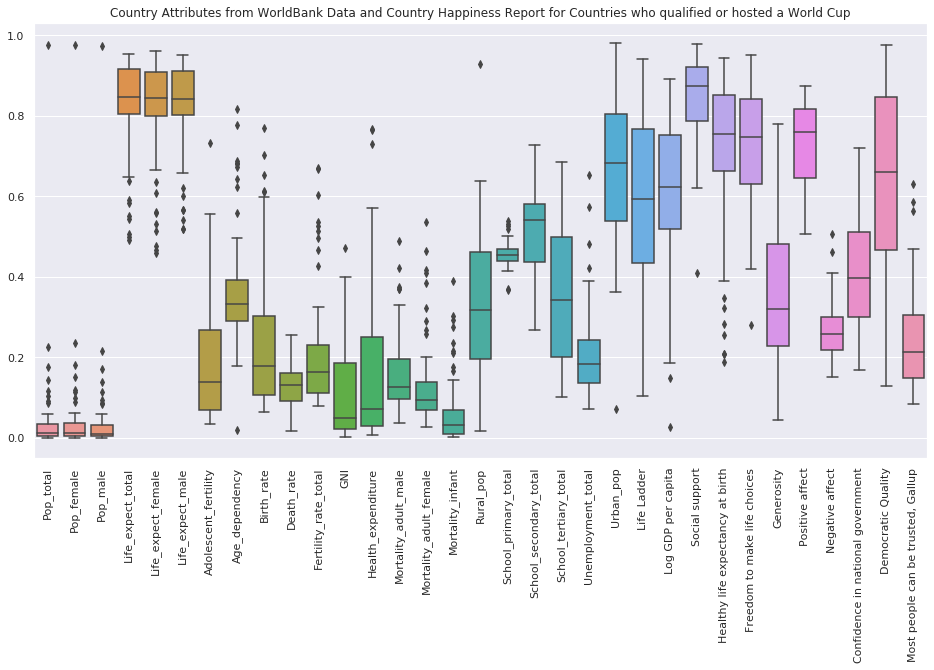

In [16]:
# same visualization for countries that were officialy involved in a WorldCup, meaning they qualified or hosted.
# limit worldBank data to range of years of happiness report data 
# limit both WorldBank data and happiness report data to successful countries
home_team = worldCup.home_team.unique()
away_team = worldCup.away_team.unique()
host_country = worldCup.country.unique()

involved_countries = list(home_team)
potent_doubles = list(away_team) + list(host_country)

for cntr in potent_doubles:
    dble = False
    for nation in involved_countries:
        if cntr == nation:
            dble = True
    if not dble:
        involved_countries.append(cntr)

# limit WorldBank Data to year range from happiness report.
fifa_wb = wb[wb.Year >= 2005]
fifa_country_happiness_data = country_happiness_data[country_happiness_data.country.isin(involved_countries)]
fifa_wb = fifa_wb[fifa_wb['Country_Name'].isin(involved_countries)]

# average datasets
fifa_average_wb = fifa_wb.drop('Year', axis=1)
fifa_average_wb = fifa_average_wb.groupby("Country_Name").mean()
fifa_average_happy = fifa_country_happiness_data.drop('year', axis=1)
fifa_average_happy = fifa_average_happy.groupby('country').mean()

# delete countries in WorldBank data that are not included in happiness report.
solo_countries = []
for wb_cntr in fifa_average_wb.index:
    if wb_cntr not in fifa_average_happy.index:
        solo_countries.append(wb_cntr)

fifa_average_wb = fifa_average_wb.drop(solo_countries)

# join averages from both datasets WorldBank and Happyness Report
fifa_joined_country_data = pd.concat([fifa_average_wb, fifa_average_happy], axis=1)
print("All involved {} countries: {}".format(len(np.array(fifa_joined_country_data.index)), 
                                             np.array(fifa_joined_country_data.index)))

# plot attribute distributions as boxplot
sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(data = fifa_joined_country_data).set_title(
    'Country Attributes from WorldBank Data and Country Happiness Report for Countries who qualified or hosted a World Cup')

plt.xticks(rotation=90);

All successful 22 countries: ['Argentina' 'Austria' 'Brazil' 'Chile' 'Croatia' 'Czech Republic'
 'France' 'Germany' 'Hungary' 'Italy' 'Japan' 'Mexico' 'Netherlands'
 'Poland' 'Portugal' 'South Africa' 'Spain' 'Sweden' 'Switzerland'
 'Turkey' 'United Kingdom' 'Uruguay']


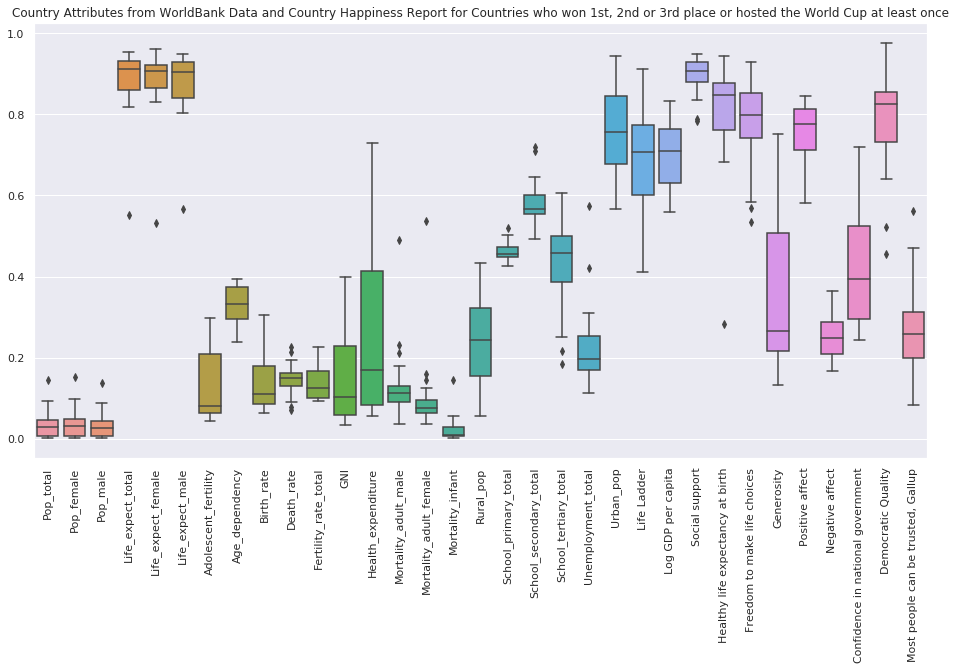

In [17]:
# same visualization for countries that made a 1st, 2nd, or 3rd place or hosted a WorldCup.
# limit worldBank data to range of years of happiness report data 
# limit both WorldBank data and happiness report data to successful countries
limited_wb = wb[wb.Year >= 2005]
limited_country_happiness_data = country_happiness_data[country_happiness_data.country.isin(successful_countries)]
limited_wb = limited_wb[limited_wb['Country_Name'].isin(successful_countries)]

# average datasets
limited_average_wb = limited_wb.drop('Year', axis=1)
limited_average_wb = limited_average_wb.groupby("Country_Name").mean()
limited_average_happy = limited_country_happiness_data.drop('year', axis=1)
limited_average_happy = limited_average_happy.groupby('country').mean()

# join averages from both datasets WorldBank and Happyness Report
limited_joined_country_data = pd.concat([limited_average_wb, limited_average_happy], axis=1)

print("All successful {} countries: {}".format(len(np.array(limited_joined_country_data.index)), 
                                               np.array(limited_joined_country_data.index)))

# plot attribute distributions as boxplot
sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(data = limited_joined_country_data).set_title(
    'Country Attributes from WorldBank Data and Country Happiness Report for Countries who won 1st, 2nd or 3rd place or hosted the World Cup at least once')

plt.xticks(rotation=90);

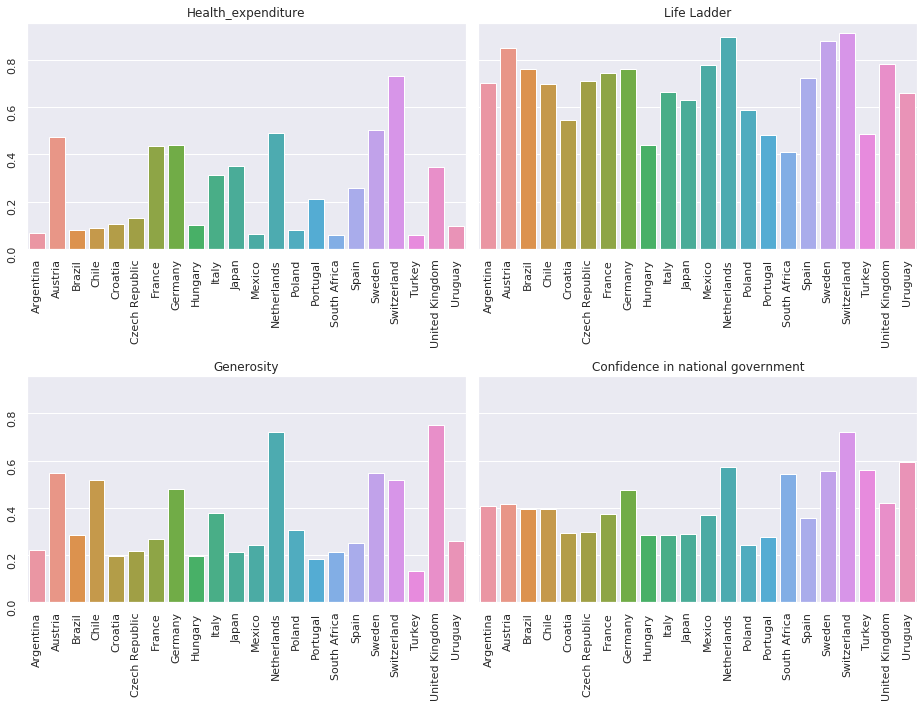

In [75]:
# checking the 3 attributes with the biggest range + Life Ladder which stands for happiness 
# by successful country in World Cup
sel_attrs = ['Health_expenditure', 'Life Ladder', 'Generosity', 'Confidence in national government']
sel_countries = limited_joined_country_data.index.values

fig1, ax1 = plt.subplots(nrows=2, ncols=2, figsize=(13,10), sharey=True)

for s in range(len(sel_attrs)):
    if s < 2:
        start = 0
        end = s
    else:
        start = 1
        end = s-2
    sns.barplot(x=limited_joined_country_data.index, y=sel_attrs[s], data = limited_joined_country_data, 
                ax=ax1[start, end]).set_title(sel_attrs[s])
    ax1[start, end].tick_params(labelrotation=90)
    ax1[start, end].set(xlabel = "", ylabel="")
    plt.tight_layout()
    plt.xticks(rotation=90);


All 128 national_teams: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Belarus' 'Belgium' 'Benin' 'Bolivia'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cameroon' 'Canada' 'Chad'
 'Chile' 'China' 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark'
 'Dominica' 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador' 'Estonia'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran, Islamic Rep.' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait' 'Latvia' 'Liberia'
 'Libya' 'Lithuania' 'Luxembourg' 'Madagascar' 'Mali' 'Malta' 'Mauritania'
 'Mexico' 'Moldova' 'Montenegro' 'Morocco' 'Mozambique' 'Namibia'
 'Netherlands' 'New Zealand' 'Nicaragua' 'Nigeria' 'Norway' 'Oman'
 'Panama' 'Paragua

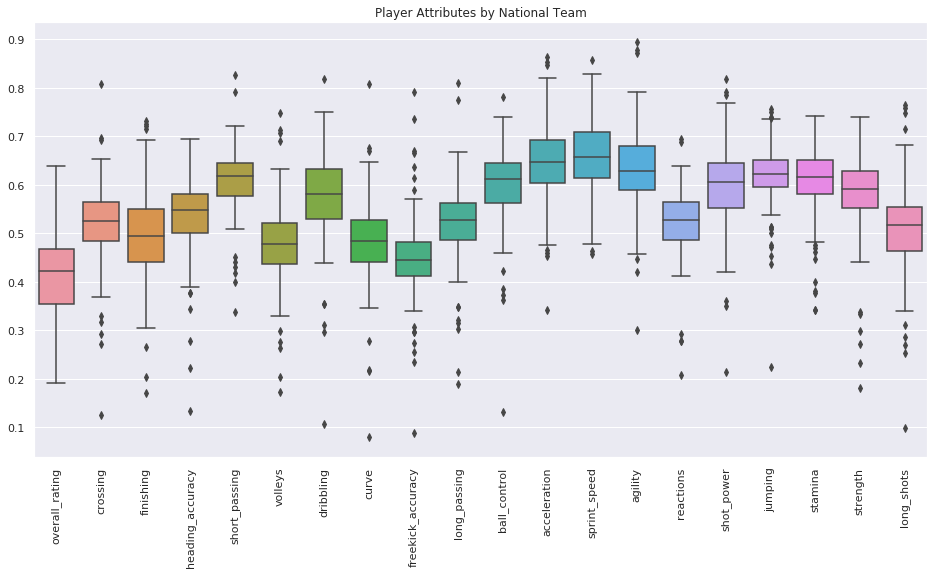

In [18]:
# visualization distribution of player skills per country
# print(fifa_top_players_data.columns)
# fifa_top_players_data.head()

top_players = fifa_top_players_data


normalized_attrs = [
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]

monetary_attrs = [
    'value_euro',
    'wage_euro'
]

categorical_attrs = [
    'positions',
    'preferred_foot'
]

average_team = top_players.groupby("national_team").mean()

# limit national team to countries in joined WorldBank and Happiness Report data set.
rest_countries = []
for c in average_team.index:
    if c not in joined_country_data.index:
        rest_countries.append(c)
        
# print(rest_countries)

attrs_by_team  = average_team.drop(rest_countries)
print("All {} national_teams: {}".format(len(np.array(attrs_by_team.index)), 
                                               np.array(attrs_by_team.index)))

sns.set(rc={'figure.figsize':(16,8)})
sns.boxplot(data = attrs_by_team[normalized_attrs]).set_title(
    'Player Attributes by National Team')
plt.xticks(rotation=90);

In [19]:
# scale monetary date to units $1000
attrs_by_team[monetary_attrs] = attrs_by_team[monetary_attrs].apply(lambda x: x / 1000)

print(attrs_by_team['value_euro'].describe())
print(attrs_by_team['wage_euro'].describe())

count      128.000000
mean      2225.777648
std       1737.092587
min        140.000000
25%        879.218750
50%       1952.815126
75%       3005.802696
max      10500.000000
Name: value_euro, dtype: float64
count    128.000000
mean       8.836357
std        7.994729
min        1.000000
25%        3.825000
50%        7.683333
75%       11.287500
max       71.000000
Name: wage_euro, dtype: float64


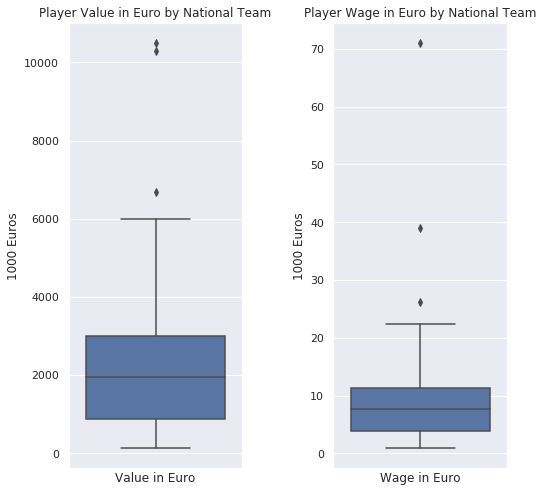

In [80]:
fig, axes = plt.subplots(1,2, figsize=(7,7))
sns.set(rc={'figure.figsize':(4,4)})
sns.boxplot(data = attrs_by_team['value_euro'], ax=axes[0]).set_title(
    'Player Value in Euro by National Team')
axes[0].set(xlabel='Value in Euro', ylabel='1000 Euros', xticks=[])
sns.boxplot(data = attrs_by_team['wage_euro'], ax=axes[1]).set_title(
    'Player Wage in Euro by National Team')
axes[1].set(xlabel = "Wage in Euro", ylabel="1000 Euros", xticks=[])
plt.tight_layout()
plt.subplots_adjust(left = 0.05)
plt.xticks(rotation=90);


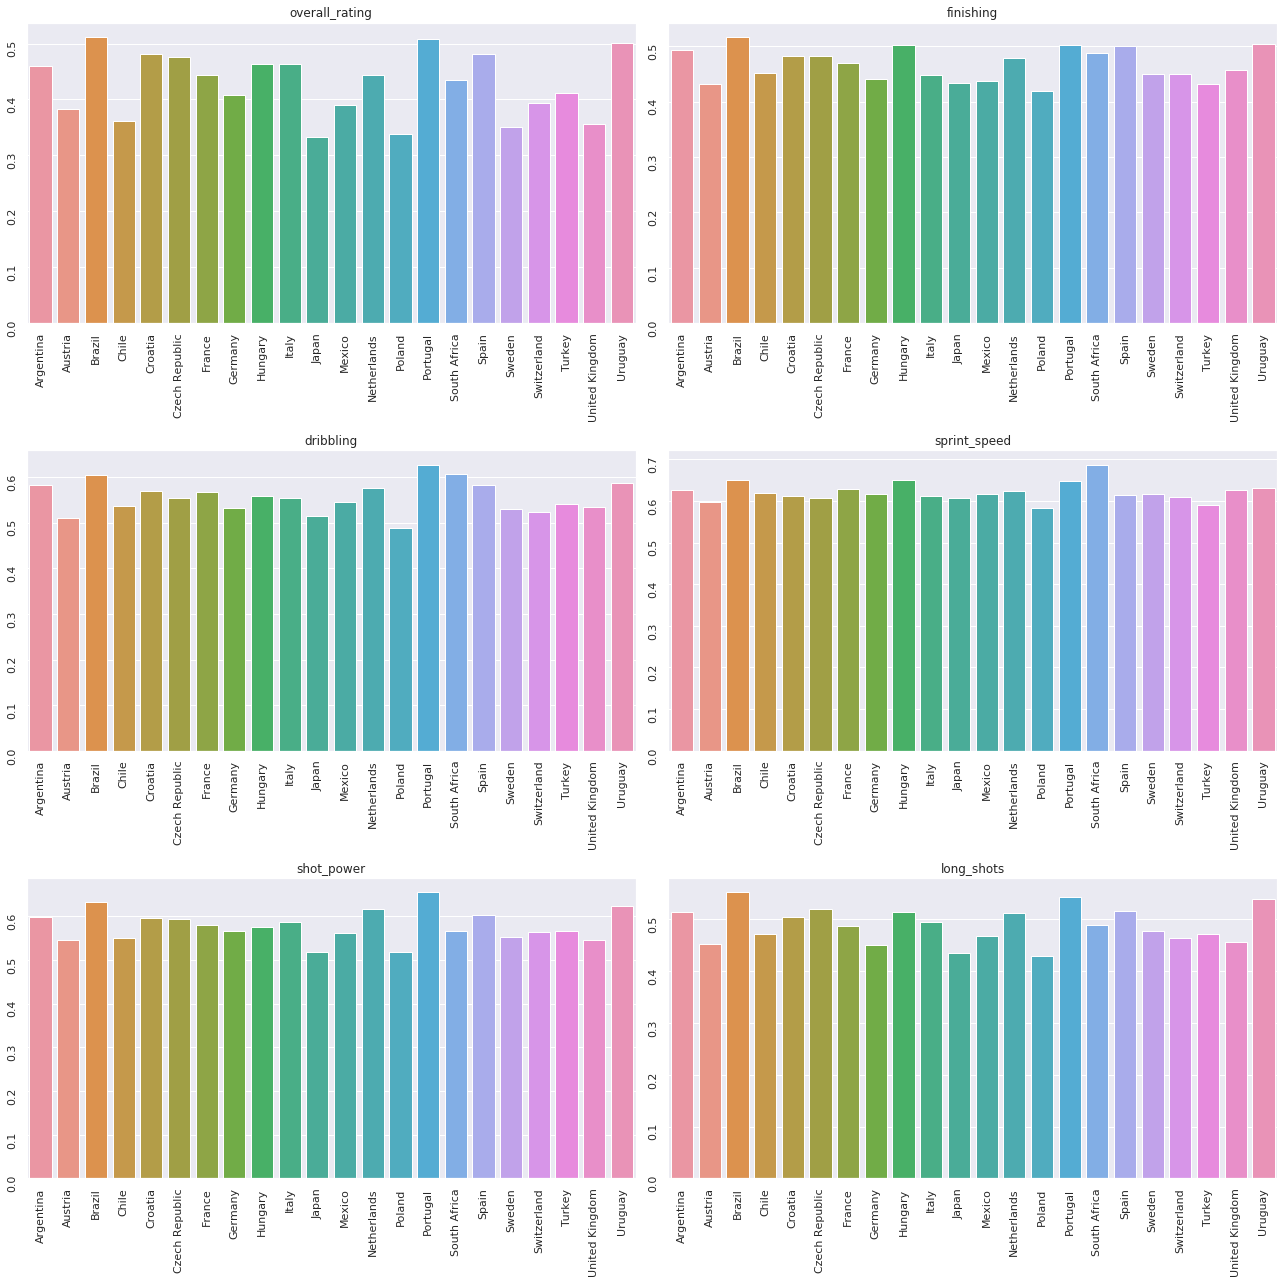

In [65]:
# Player attribute distributions by successful country for 6 attributes with widest range
selected_attrs = ['overall_rating', 'finishing', 'dribbling', 'sprint_speed', 'shot_power', 'long_shots']
attrs_by_country = attrs_by_team[selected_attrs]
attrs_by_country = attrs_by_country[attrs_by_country.index.isin(successful_countries)]
# USA and Korea are missing
selected_countries = attrs_by_country.index.values

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,18))

for i in range(len(selected_attrs)):
    if i < 2:
        start_index = 0
        end_index = i
    elif i < 4:
        start_index = 1
        end_index = i-2
    else:
        start_index = 2
        end_index = i-4
    sns.barplot(x=attrs_by_country.index, y=selected_attrs[i], data = attrs_by_country, ax=ax[start_index, end_index]).set_title(
        selected_attrs[i])
    ax[start_index, end_index].tick_params(labelrotation=90)
    ax[start_index, end_index].set(xlabel = "", ylabel="")
    plt.tight_layout()
    plt.xticks(rotation=90);

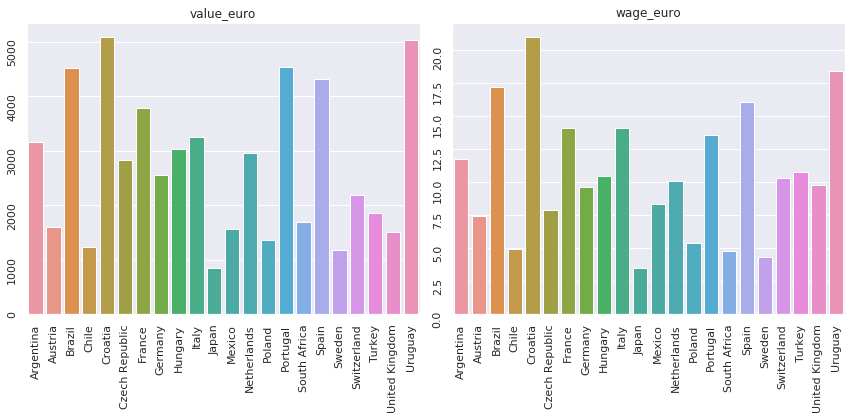

In [89]:
# Player attribute distributions by successful country for 6 attributes with widest range
monetary_attrs = [
    'value_euro',
    'wage_euro'
]
attrs_by_cntr = attrs_by_team[monetary_attrs]
attrs_by_cntr = attrs_by_cntr[attrs_by_cntr.index.isin(successful_countries)]
# USA and Korea are missing
selected_countries = attrs_by_cntr.index.values

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

for i in range(len(monetary_attrs)):
    if i < 2:
        start_i = 0
        end_i = i

    sns.barplot(x=attrs_by_cntr.index, y=monetary_attrs[i], data = attrs_by_cntr, ax=ax2[end_i]).set_title(
        monetary_attrs[i])
    ax2[end_i].tick_params(labelrotation=90)
    ax2[end_i].set(xlabel = "", ylabel="Euros in 1000")
    plt.tight_layout()
    plt.xticks(rotation=90);